In [121]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
# from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
# from sklearn.preprocessing import normalize
import scipy.io
import scipy.optimize as op

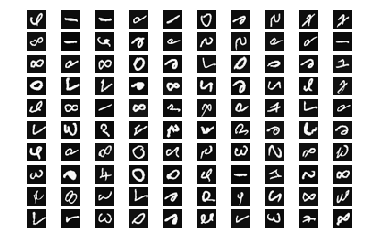

In [122]:
mat = scipy.io.loadmat('./ex4/ex4data1.mat')
mat2 = scipy.io.loadmat('./ex4/ex4weights.mat')
X = mat.get('X')
y = mat.get('y')

input_layer_size  = 400;  # 20x20 Input Images of Digits
hidden_layer_size = 25;   # 25 hidden units
hidden_layer_sizes = [25]
output_layer_size = 10

# layers = [input_layer_size, hidden_layer_size, output_layer_size]
layer_sizes = [input_layer_size, *hidden_layer_sizes, output_layer_size]

layers = []
size = 0
for l1, l2 in zip(layer_sizes[:-1], layer_sizes[1:]):
    size += l2 * (l1 + 1)
    layers.append((l2, l1 + 1))

thetas = np.ones(size)
# thetas = np.random.random(size)

m = len(y)

Theta1 = mat2.get('Theta1') # 25 x 401
Theta2 = mat2.get('Theta2') # 10 x 26

# thetas = np.concatenate((Theta1.flatten(), Theta2.flatten()))

images_count = len(X)
display_count = 10
img_size = int(math.sqrt(len(X[0])))

random_images = X[np.random.choice(len(X), display_count ** 2)]

for i in range(display_count):
    for j in range(display_count):
        img_num = i * 10 + j
        img = random_images[img_num].reshape(img_size, img_size)
        plt.subplot(display_count, display_count, img_num + 1)
        plt.imshow(img, cmap='Greys_r')
        plt.axis('off')
plt.show()

ones = np.ones((images_count, 1))
X = np.column_stack((ones, X))

# y = y.ravel()
# y[y == 10] = 0
y_new = np.zeros((m, output_layer_size))
y_new[np.arange(0, m),y.ravel() - 1] = 1
y = y_new

In [123]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def sigmoidGradient(z):
    return z * (1 - z)

def compute_cost1(theta1, theta2, X, y, lambdaa=0):
    A1 = sigmoid(X.dot(theta1.T))
    
    ones = np.ones((len(A1), 1))
    A1 = np.column_stack((ones, A1))
    
    A2 = sigmoid(A1.dot(theta2.T))
    h = A2
    
    m = len(y)
    cost = 1 / m * np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h))
    
    theta1_reg = theta1[1:]
    theta2_reg = theta2[1:]

    cost_reg = lambdaa / 2 / m * (np.sum(theta1_reg ** 2) + np.sum(theta2_reg ** 2))

    cost += cost_reg
    return cost

cost = compute_cost1(Theta1, Theta2, X, y)
print('Cost at parameters: {:.6f} (should be about 0.287629)'.format(cost));

cost = compute_cost1(Theta1, Theta2, X, y, lambdaa=1)
print('Cost at parameters: {:.6f} (should be about 0.383770)'.format(cost));

g = sigmoidGradient(sigmoid(np.array([-1, -0.5, 0, 0.5, 1])));
print('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]: \n {}'.format(g));

Cost at parameters: 0.287629 (should be about 0.287629)
Cost at parameters: 0.379046 (should be about 0.383770)
Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]: 
 [0.19661193 0.23500371 0.25       0.23500371 0.19661193]


In [143]:
def extract_thetas(thetas_flat, layers):
    thetas = []
    
    start = 0
    for layer_cols, layer_rows in layers:
        theta_size = layer_cols*layer_rows
        thetas.append(thetas_flat[start:start + theta_size].reshape(layer_cols, layer_rows))
        start += theta_size
        
    return thetas

def predict_with_activations(X, thetas):
    *first_thetas, last_theta = thetas
    A = X
    As = [X]
    for theta in first_thetas:
        A = sigmoid(A.dot(theta.T))
        ones = np.ones((len(A), 1))
        A = np.column_stack((ones, A))
        As.append(A)
        
    A = sigmoid(A.dot(last_theta.T))
    As.append(A)

    return A, As

def predict(X, thetas):
    h, _ = predict_with_activations(X, thetas)
    return h

def compute_cost(thetas_flat, layers, X, y, lambdaa=0, reg=True):
    thetas = extract_thetas(thetas_flat, layers)
    h, _ = predict_with_activations(X, thetas)
    
    m = len(y)
    cost = 1 / m * np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h))
    for theta in thetas:
        theta_reg = theta[1:]
        cost += lambdaa / 2 / m * np.sum(theta_reg ** 2)
    
#     print('cost: ', cost)
    return cost

thetas_test = np.concatenate((Theta1.flatten(), Theta2.flatten()))

cost = compute_cost(thetas_test, layers, X, y)
print('Cost at parameters: {:.6f} (should be about 0.287629)'.format(cost));

cost = compute_cost(thetas_test, layers, X, y, lambdaa=1)
print('Cost at parameters: {:.6f} (should be about 0.383770)'.format(cost));

g = sigmoidGradient(sigmoid(np.array([-1, -0.5, 0, 0.5, 1])));
print('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]: \n {}'.format(g));

Cost at parameters: 0.287629 (should be about 0.287629)
Cost at parameters: 0.379046 (should be about 0.383770)
Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]: 
 [0.19661193 0.23500371 0.25       0.23500371 0.19661193]


In [152]:
def backpropagation_step(thetas_flat, layers, X, y, lambdaa=0):
    print('backpropagation_step')
    thetas = extract_thetas(thetas_flat, layers)
    h, As = predict_with_activations(X, thetas)
    error = h - y # 5000 x 10
    deltas = [error.T.dot(As[-2])]
    
    for i in range(len(thetas) - 1, 0, -1):
        error = error.dot(thetas[i]) * sigmoidGradient(As[i])
        deltas.insert(0, error[:,1:].T.dot(As[i - 1]))
    
    theta_grads = []
    for theta, delta in zip(thetas, deltas):
        theta_reg = theta.copy()
        theta_reg[:,0] = 0
        theta_grad = delta / m + lambdaa * theta_reg
        theta_grads.append(theta_grad.flatten())
    
    return np.concatenate(theta_grads)

# thetas_test = np.concatenate((Theta1.flatten(), Theta2.flatten()))
thetas_test = thetas
grads = sum(backpropagation_step(thetas_test, layers, X, y))
print('Grads: {:.6f} (should be about 234.000002)'.format(grads));

grads = sum(backpropagation_step(thetas_test, layers, X, y, 0.1))
print('Grads: {:.6f} (should be about 1259.000002)'.format(grads));

thetas_test = np.concatenate((Theta1.flatten(), Theta2.flatten()))
grads = sum(backpropagation_step(thetas_test, layers, X, y))
print('Grads: {:.6f} (should be about 0.026047)'.format(grads));

thetas_test = np.concatenate((Theta1.flatten(), Theta2.flatten()))
grads = sum(backpropagation_step(thetas_test, layers, X, y, 0.1))
print('Grads: {:.6f} (should be about -8.019701)'.format(grads));

# print(thetas_test)

backpropagation_step
Grads: 234.000002 (should be about 234.000002)
backpropagation_step
Grads: 1259.000002 (should be about 1259.000002)
backpropagation_step
Grads: 0.026047 (should be about 0.026047)
backpropagation_step
Grads: -8.019701 (should be about -8.019701)


In [127]:
thetas_to_compute = np.concatenate((Theta1.flatten(), Theta2.flatten()))
thetas_to_compute = thetas
result = op.fmin_cg(f = compute_cost,
                    x0 = thetas_to_compute,
                    args = (layers, X, y),
                    fprime = backpropagation_step)

result_thetas = extract_thetas(result, layers)

predictions = predict(X, result_thetas)
# print('predictions: ', predictions)
predictions = np.argmax(predictions, axis=1) + 1

num_correct = 0
for prediction, actual in zip(predictions, mat.get('y')):
    num_correct += 1 if prediction == actual else 0
    
print('correct %: ', 1.0 * num_correct / len(y) * 100)

cost:  234.00011376290155
cost:  219.34284877569834
cost:  160.71407713252302
cost:  8.20284325308757
cost:  219.34284877569834
cost:  204.68562856953733
cost:  175.3712612773667
cost:  116.7425464757342
cost:  6.706695315118939
cost:  26.114434064444474
cost:  10.977288804200372
cost:  4.450830519183106
cost:  3.3638261531451965
cost:  3.252842994291696
cost:  3.2508317314599213
cost:  3.2508297339384202
Optimization terminated successfully.
         Current function value: 3.250830
         Iterations: 1
         Function evaluations: 16
         Gradient evaluations: 14
correct %:  10.0


In [159]:
thetas_to_compute = np.concatenate((Theta1.flatten(), Theta2.flatten()))
thetas_to_compute = thetas
result = op.minimize(fun = compute_cost,
                     x0 = thetas_to_compute,
                     args = (layers, X, y, 0.03),
                     jac = backpropagation_step,
                     method ='CG',
#                      tol=0.000000000001,
                     options = {'maxiter': 2,'disp': True})

result_thetas = extract_thetas(result.x, layers)
print('original_thetas: ', thetas_to_compute)
print('result_thetas: ', result.x)
predictions = predict(X, result_thetas)
# print('predictions: ', predictions)
predictions = np.argmax(predictions, axis=1) + 1

num_correct = 0
for prediction, actual in zip(predictions, mat.get('y')):
    num_correct += 1 if prediction == actual else 0
    
print('correct %: ', 1.0 * num_correct / len(y) * 100)

# res2 = optimize.minimize(f, x0, jac=gradf, args=args,
# ...                          method='CG', options=opts)

backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagation_step
backpropagati